In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus'] = False 
sns.set_theme(style="darkgrid", font_scale = 1.3, rc={'font.sans-serif':['Arial Unicode MS','Arial']})

### get player statistics table

In [11]:
from PStatsScraper.PlayerStatisticTable import PlayerStatisticTable
player_ststistic_table = PlayerStatisticTable(english_col=True)

season :  ['2020-21', '2021-22']
game_type :  ['例行賽', '季後賽', '總冠軍賽']
team :  ['全部球隊', '臺北富邦勇士', '新北國王', '桃園領航猿', '新竹街口攻城獅', '福爾摩沙台新夢想家', '高雄鋼鐵人']
stat_type :  ['平均', '累計']


In [12]:
col_dtype = {
    'games' : 'int32',
    '2PM' : 'float64',
    '2PA' : 'float64',
    '3PM' : 'float64',
    '3PA' : 'float64',
    'FTM' : 'float64',
    'FTA' : 'float64',
    'points' : 'float64',
    'REB_O' : 'float64',
    'REB_D' : 'float64',
    'REB' : 'float64',
    'AST' : 'float64',
    'STL' : 'float64',
    'BLK' : 'float64',
    'TO' : 'float64',
    'PF' : 'float64'
}
def percentage_to_float(percentage):
    return round( float(percentage[:-1]) / 100, 2)
def convert_mins(mins):
    return round(float(mins.split(':')[0]) + float(mins.split(':')[1])/60,2)
all_player_table = (
    player_ststistic_table.get_table(season='2021-22',game_type='例行賽',team='全部球隊',stat_type='平均')
        .astype(col_dtype)
        .sort_values(by = ['points', 'AST'],ascending = False)
)
for stat in ['2P%','3P%','FT%']:
    all_player_table[stat] = all_player_table[stat].map(percentage_to_float)
all_player_table['mins'] = all_player_table['mins'].map(convert_mins)
all_player_table.head(3)

,player,jersey,team,games,mins,2PM,2PA,2P%,3PM,3PA,...,FT%,points,REB_O,REB_D,REB,AST,STL,BLK,TO,PF
2,辛巴,35,新竹街口攻城獅,27,39.33,10.22,15.30,0.67,0.04,0.11,...,0.58,26.33,6.48,14.33,20.81,2.26,0.63,2.48,2.96,2.15
13,班尼特,20,高雄鋼鐵人,13,34.77,7.08,11.62,0.61,2.38,7.54,...,0.78,25.23,3.85,10.23,14.08,1.77,1.38,1.08,3.08,3.08
14,法獅,7,新竹街口攻城獅,23,34.55,5.91,13.78,0.43,2.96,8.65,...,0.78,24.83,2.22,7.61,9.83,2.96,1.78,0.39,3.22,2.13


In [51]:
all_player_table['games'].quantile(0.1)

7.200000000000001

In [13]:
all_player_table['mins'].quantile(0.1)

7.648000000000001

In [15]:
# remains players with enough games ( > 10% percentile) 
enough_game_player_table = all_player_table[
                                    (all_player_table['games'] > all_player_table['games'].quantile(0.1))
                                    & (all_player_table['mins'] > all_player_table['mins'].quantile(0.1))
                                ]
enough_game_player_table.shape

(80, 23)

### Select Features

In [17]:
target_feature_table = enough_game_player_table[['player','2P%','3P%','points','REB','AST','STL','BLK']]

In [33]:
target_feature_table

,player,2P%,3P%,points,REB,AST,STL,BLK
2,辛巴,0.67,0.33,26.33,20.81,2.26,0.63,2.48
13,班尼特,0.61,0.32,25.23,14.08,1.77,1.38,1.08
14,法獅,0.43,0.34,24.83,9.83,2.96,1.78,0.39
17,羅賓森,0.53,0.30,24.61,12.48,2.70,2.04,1.26
10,辛特力,0.53,0.33,21.86,11.77,4.59,1.41,0.68
...,...,...,...,...,...,...,...,...
64,林明毅,0.18,0.22,1.57,1.79,1.21,0.36,0.21
79,林耀宗,0.33,0.00,1.56,1.81,0.88,0.13,0.38
81,吳岱豪,0.39,0.40,1.50,1.50,0.54,0.43,0.18
77,楊盛硯,0.31,0.12,1.33,1.10,1.10,0.71,0.00


In [18]:
target_feature_table.describe().round(2)

,2P%,3P%,points,REB,AST,STL,BLK
count,80.00,80.00,80.00,80.00,80.00,80.00,80.00
mean,0.44,0.29,8.86,4.66,1.93,0.88,0.37
std,0.10,0.10,6.52,4.02,1.49,0.54,0.53
min,0.18,0.00,1.15,0.94,0.09,0.13,0.00
25%,0.39,0.25,3.78,1.99,0.85,0.45,0.07
50%,0.43,0.31,6.35,3.30,1.66,0.78,0.18
75%,0.49,0.35,12.49,4.87,2.69,1.25,0.39
max,0.67,0.50,26.33,20.81,8.41,2.25,3.00


### Standardize Features

In [19]:
scaler = StandardScaler()
standardize_player_table = scaler.fit_transform(target_feature_table.drop(columns='player'))

## Clustering (K-means)

### select k 
- test from 2 - 10
- use Silhouette to measure

In [20]:
silhouette = list()
wcss = list()
for k in range(3,11):
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 3)
    kmeans.fit(standardize_player_table)
    silhouette.append(silhouette_score(standardize_player_table, kmeans.labels_))
    wcss.append(kmeans.inertia_)

Text(0.5, 1.0, 'Silhouette')

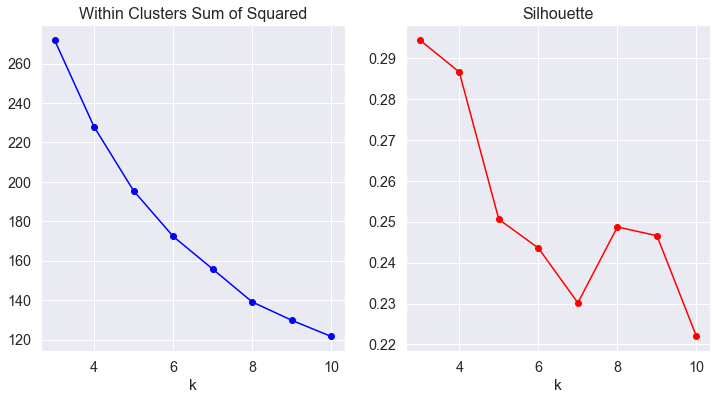

In [21]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].plot(range(3, 11), wcss, marker='o', linestyle='-',color='blue')
ax[0].set_xlabel('k')
ax[0].set_title('Within Clusters Sum of Squared', fontsize=16)

ax[1].plot(range(3, 11), silhouette, marker='o', linestyle='-',color='red')
ax[1].set_xlabel('k')
ax[1].set_title('Silhouette', fontsize=16)

### clustering with k = 6

In [22]:
target_k = 6
kmeans = KMeans(n_clusters = target_k, init = 'k-means++', random_state = 3)
kmeans.fit(standardize_player_table)

KMeans(n_clusters=6, random_state=3)

In [23]:
table_with_cluseter = pd.concat([target_feature_table.reset_index(drop=True), pd.DataFrame(kmeans.labels_,columns=['cluster'])], axis=1)
table_with_cluseter.head()

,player,2P%,3P%,points,REB,AST,STL,BLK,cluster
0,辛巴,0.67,0.33,26.33,20.81,2.26,0.63,2.48,0
1,班尼特,0.61,0.32,25.23,14.08,1.77,1.38,1.08,4
2,法獅,0.43,0.34,24.83,9.83,2.96,1.78,0.39,4
3,羅賓森,0.53,0.30,24.61,12.48,2.70,2.04,1.26,4
4,辛特力,0.53,0.33,21.86,11.77,4.59,1.41,0.68,4


Text(0, 0.5, '場均抄截')

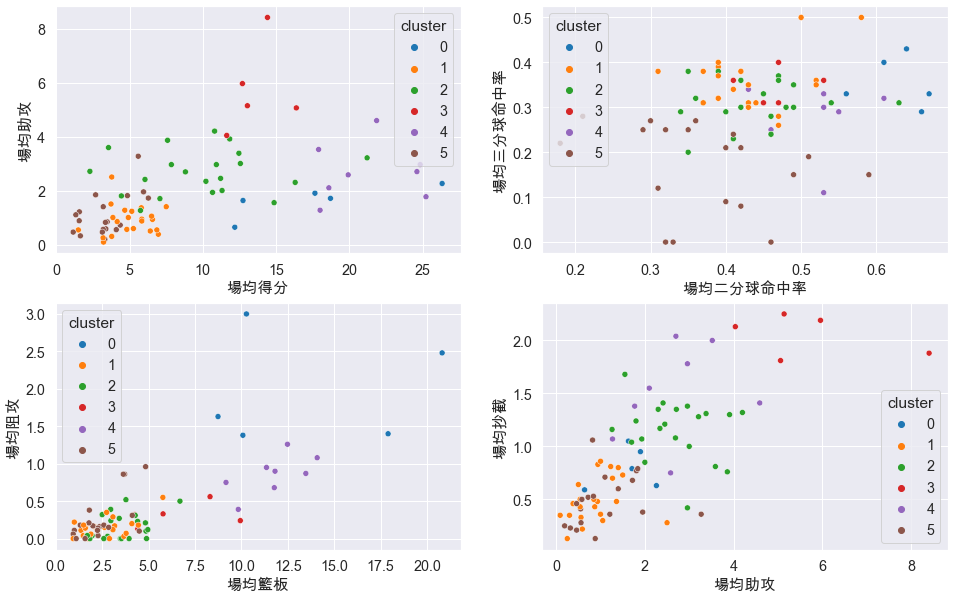

In [24]:
cluster_palette = sns.color_palette("tab10")[:target_k]

fig, ax = plt.subplots(2,2,figsize=(16,10))
sns.scatterplot(data=table_with_cluseter,x='points',y='AST',hue='cluster',ax=ax[0][0],palette=cluster_palette)
ax[0][0].set_xlabel('場均得分')
ax[0][0].set_ylabel('場均助攻')

sns.scatterplot(data=table_with_cluseter,x='2P%',y='3P%',hue='cluster',ax=ax[0][1],palette=cluster_palette)
ax[0][1].set_xlabel('場均二分球命中率')
ax[0][1].set_ylabel('場均三分球命中率')

sns.scatterplot(data=table_with_cluseter,x='REB',y='BLK',hue='cluster',ax=ax[1][0],palette=cluster_palette)
ax[1][0].set_xlabel('場均籃板')
ax[1][0].set_ylabel('場均阻攻')

sns.scatterplot(data=table_with_cluseter,x='AST',y='STL',hue='cluster',ax=ax[1][1],palette=cluster_palette)
ax[1][1].set_xlabel('場均助攻')
ax[1][1].set_ylabel('場均抄截')

In [25]:
table_with_cluseter[table_with_cluseter['cluster']==3]

,player,2P%,3P%,points,REB,AST,STL,BLK,cluster
12,里金斯,0.47,0.40,16.38,8.31,5.06,1.81,0.56,3
15,布朗,0.53,0.36,14.41,9.94,8.41,1.88,0.24,3
16,陳又瑋,0.45,0.31,13.04,4.25,5.14,2.25,0.32,3
18,李愷諺,0.47,0.31,12.70,5.78,5.96,2.19,0.33,3
23,高國豪,0.41,0.36,11.63,4.42,4.04,2.13,0.13,3


In [26]:
table_with_cluseter[table_with_cluseter['cluster']==1]

,player,2P%,3P%,points,REB,AST,STL,BLK,cluster
33,朱雲豪,0.47,0.28,7.50,3.17,1.40,0.80,0.17,1
35,藍少甫,0.43,0.35,6.96,3.08,0.38,0.46,0.29,1
36,簡祐哲,0.52,0.36,6.86,1.36,0.54,0.50,0.11,1
37,成力煥,0.39,0.32,6.56,2.63,0.93,0.48,0.15,1
38,王柏智,0.42,0.38,6.50,4.10,1.05,0.30,0.20,1
39,石博恩,0.52,0.35,6.41,5.77,0.50,0.64,0.55,1
43,陳振傑,0.43,0.31,5.83,2.89,0.94,0.83,0.00,1
44,王律翔,0.43,0.30,5.83,1.48,0.87,0.43,0.04,1
45,陳堅恩,0.43,0.35,5.80,2.08,1.36,0.48,0.16,1
48,郭少傑,0.39,0.39,5.26,1.67,0.59,0.22,0.04,1


In [27]:
table_with_cluseter[table_with_cluseter['cluster']==4]

,player,2P%,3P%,points,REB,AST,STL,BLK,cluster
1,班尼特,0.61,0.32,25.23,14.08,1.77,1.38,1.08,4
2,法獅,0.43,0.34,24.83,9.83,2.96,1.78,0.39,4
3,羅賓森,0.53,0.30,24.61,12.48,2.70,2.04,1.26,4
4,辛特力,0.53,0.33,21.86,11.77,4.59,1.41,0.68,4
6,揚科維奇,0.55,0.29,19.92,9.17,2.58,0.75,0.75,4
8,布依德,0.46,0.25,18.60,11.35,2.10,1.55,0.95,4
9,班森,0.53,0.11,18.00,13.47,1.27,1.07,0.87,4
10,喬丹,0.55,0.29,17.90,11.81,3.52,2.00,0.90,4


In [28]:
table_with_cluseter[table_with_cluseter['cluster']==0]

,player,2P%,3P%,points,REB,AST,STL,BLK,cluster
0,辛巴,0.67,0.33,26.33,20.81,2.26,0.63,2.48,0
7,塞瑟夫,0.61,0.40,18.71,10.08,1.71,0.79,1.38,0
11,湯瑪士,0.66,0.29,17.65,17.90,1.90,0.95,1.40,0
17,戴維斯,0.64,0.43,12.74,8.74,1.63,1.05,1.63,0
21,吉爾貝克,0.56,0.33,12.18,10.27,0.64,0.59,3.00,0


In [29]:
table_with_cluseter[table_with_cluseter['cluster']==2]

,player,2P%,3P%,points,REB,AST,STL,BLK,cluster
5,楊敬敏,0.45,0.33,21.21,4.86,3.21,1.28,0.10,2
13,呂政儒,0.48,0.30,16.30,3.78,2.30,1.35,0.52,2
14,盧峻翔,0.42,0.36,14.86,4.41,1.55,1.68,0.23,2
19,周儀翔,0.40,0.29,12.56,4.89,3.00,1.00,0.00,2
20,張宗憲,0.41,0.23,12.46,3.08,3.38,1.31,0.12,2
22,林書緯,0.54,0.31,11.83,2.96,3.91,1.30,0.39,2
24,忻沃克,0.47,0.37,11.31,6.69,2.00,0.85,0.50,2
25,錢肯尼,0.35,0.38,11.21,4.83,2.45,1.21,0.21,2
26,林志傑,0.63,0.31,10.92,4.96,2.96,0.42,0.12,2
27,林俊吉,0.49,0.35,10.80,3.48,4.20,1.32,0.00,2


In [30]:
table_with_cluseter[table_with_cluseter['cluster']==5]

,player,2P%,3P%,points,REB,AST,STL,BLK,cluster
40,李德威,0.40,0.21,6.28,4.84,1.72,0.68,0.96,5
42,李家瑞,0.49,0.15,5.95,3.71,1.95,0.38,0.86,5
47,曾文鼎,0.59,0.15,5.59,3.64,3.27,0.36,0.86,5
51,陳冠全,0.32,0.25,4.85,4.12,1.81,0.77,0.31,5
55,張文平,0.29,0.25,4.36,2.36,0.72,0.52,0.16,5
57,李盈鋒,0.35,0.25,4.09,2.27,0.55,0.41,0.14,5
63,李家慷,0.41,0.24,3.47,1.00,0.84,0.53,0.11,5
64,楊興治,0.46,0.00,3.38,2.00,0.58,0.50,0.17,5
65,鄭德維,0.30,0.27,3.35,2.59,0.82,1.06,0.18,5
66,林力仁,0.21,0.28,3.31,0.94,0.19,0.25,0.06,5


### give each cluster a name

In [34]:
cluster_name_map = {
    3 : "主力控球球員",
    1 : "主力鋒線球員",
    4 : "主力內線球員",
    5 : "內線角色球員",
    2 : "一般先發球員",
    0 : "一般球員"
}

table_with_cluseter_name = table_with_cluseter.copy()
table_with_cluseter_name['cluster_name'] = table_with_cluseter_name['cluster'].map(cluster_name_map)

Text(0, 0.5, '場均抄截')

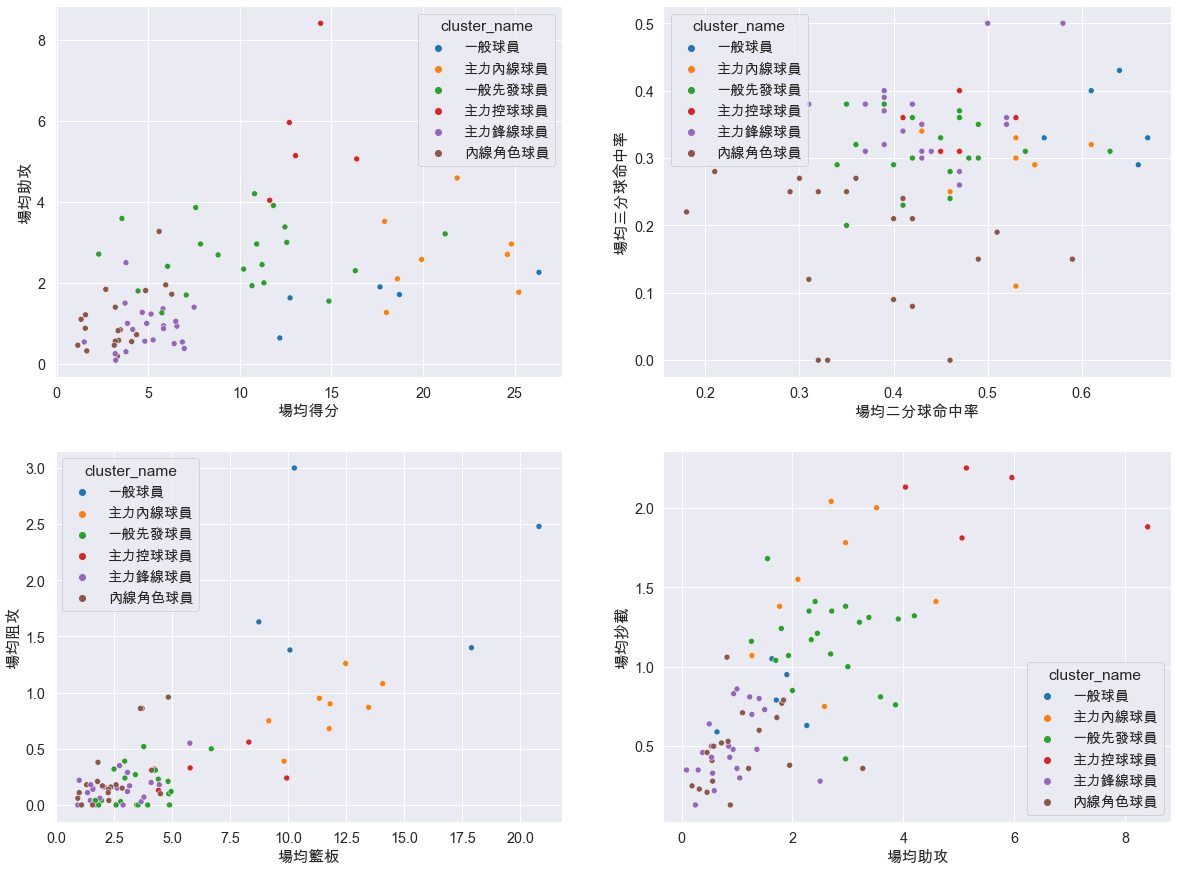

In [35]:
cluster_palette = sns.color_palette("tab10")[:target_k]

fig, ax = plt.subplots(2,2,figsize=(20,15))
sns.scatterplot(data=table_with_cluseter_name,x='points',y='AST',hue='cluster_name',ax=ax[0][0],palette=cluster_palette)
ax[0][0].set_xlabel('場均得分')
ax[0][0].set_ylabel('場均助攻')

sns.scatterplot(data=table_with_cluseter_name,x='2P%',y='3P%',hue='cluster_name',ax=ax[0][1],palette=cluster_palette)
ax[0][1].set_xlabel('場均二分球命中率')
ax[0][1].set_ylabel('場均三分球命中率')

sns.scatterplot(data=table_with_cluseter_name,x='REB',y='BLK',hue='cluster_name',ax=ax[1][0],palette=cluster_palette)
ax[1][0].set_xlabel('場均籃板')
ax[1][0].set_ylabel('場均阻攻')

sns.scatterplot(data=table_with_cluseter_name,x='AST',y='STL',hue='cluster_name',ax=ax[1][1],palette=cluster_palette)
ax[1][1].set_xlabel('場均助攻')
ax[1][1].set_ylabel('場均抄截')

Text(0, 0.5, '場均抄截')

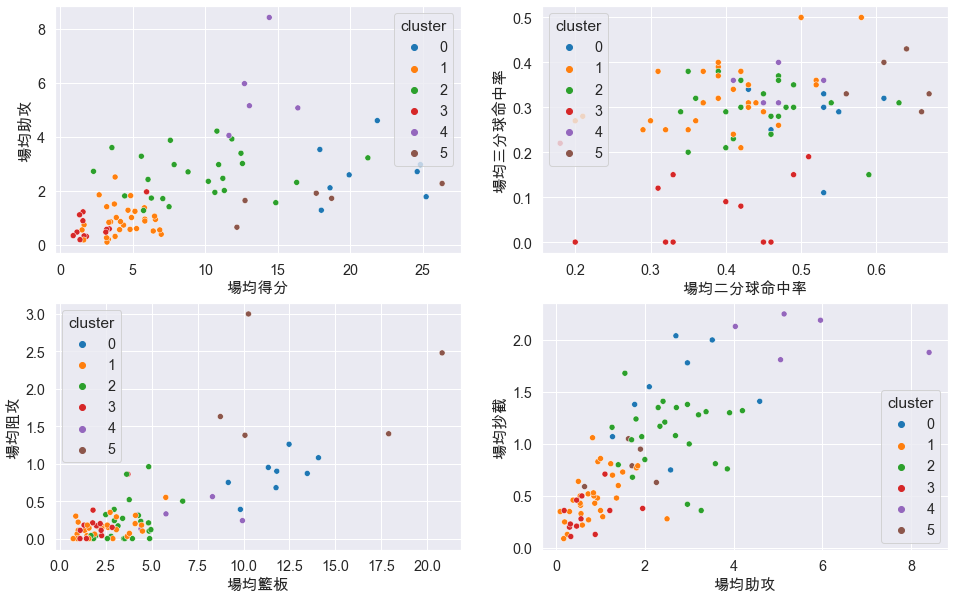

In [145]:
# different random state

target_k = 6
kmeans = KMeans(n_clusters = target_k, init = 'k-means++', random_state = 4)
kmeans.fit(standardize_player_table)

table_with_cluseter = pd.concat([target_feature_table.reset_index(drop=True), pd.DataFrame(kmeans.labels_,columns=['cluster'])], axis=1)
table_with_cluseter.head()

cluster_palette = sns.color_palette("tab10")[:target_k]

fig, ax = plt.subplots(2,2,figsize=(16,10))
sns.scatterplot(data=table_with_cluseter,x='points',y='AST',hue='cluster',ax=ax[0][0],palette=cluster_palette)
ax[0][0].set_xlabel('場均得分')
ax[0][0].set_ylabel('場均助攻')

sns.scatterplot(data=table_with_cluseter,x='2P%',y='3P%',hue='cluster',ax=ax[0][1],palette=cluster_palette)
ax[0][1].set_xlabel('場均二分球命中率')
ax[0][1].set_ylabel('場均三分球命中率')

sns.scatterplot(data=table_with_cluseter,x='REB',y='BLK',hue='cluster',ax=ax[1][0],palette=cluster_palette)
ax[1][0].set_xlabel('場均籃板')
ax[1][0].set_ylabel('場均阻攻')

sns.scatterplot(data=table_with_cluseter,x='AST',y='STL',hue='cluster',ax=ax[1][1],palette=cluster_palette)
ax[1][1].set_xlabel('場均助攻')
ax[1][1].set_ylabel('場均抄截')